Generating a PFDHA model for the Ridgecrest, Landers, Hector Mine, and El Mayor Cucapah events based on displacement and fracture data from each event. The model uses the equation below, based on the average displacement and rupture density decays for each event (see the two MCMC scripts)

\begin{equation}
   P(S>S_{0}|x,M_{w}) =  \nu_{o} (\frac{x+x_f}{x_f})^{-\gamma} e^{\frac{-S_{0}}{\beta}(\frac{x+x_S}{x_S})^{n}} 
   \end{equation}

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from random import sample

# load general model data
best_fit_parameters_general_density = np.loadtxt('MCMC_outputs/general_density_best_fit_parameters.txt', delimiter=' ')
general_g = best_fit_parameters_general_density[2]
general_xfr = best_fit_parameters_general_density[1]
general_vo = best_fit_parameters_general_density[0]


In [72]:
Ridgecrest1_displacement_parameters = np.loadtxt('MCMC_outputs/Ridgecrest1_parameters_displacement.txt', delimiter=' ')
Ridgecrest2_displacement_parameters = np.loadtxt('MCMC_outputs/Ridgecrest2_parameters_displacement.txt', delimiter=' ')
Landers_displacement_parameters = np.loadtxt('MCMC_outputs/Landers_parameters_displacement.txt', delimiter=' ')
HectorMine_displacement_parameters = np.loadtxt('MCMC_outputs/HectorMine_parameters_displacement.txt', delimiter=' ')
EMC_displacement_parameters = np.loadtxt('MCMC_outputs/EMC_parameters_displacement.txt', delimiter=' ')

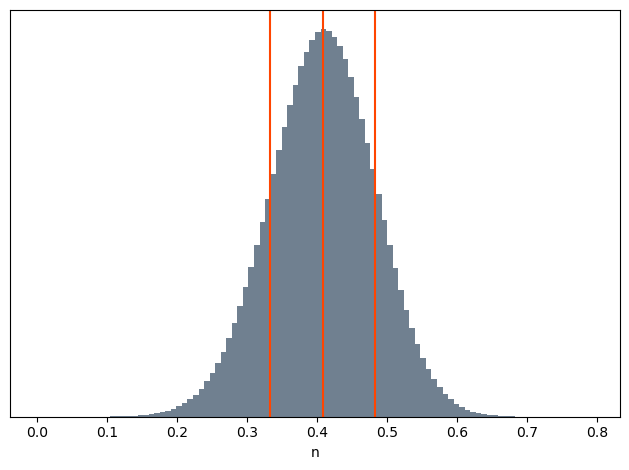

In [73]:
add_posteriors_n = np.concatenate(( Ridgecrest2_displacement_parameters[:,1] , Landers_displacement_parameters[:,1] , EMC_displacement_parameters[:,1]))
mean_n = np.mean(add_posteriors_n)
std_n = np.std(add_posteriors_n)

plt.figure()
plt.hist(add_posteriors_n,color='slategrey',bins=100)
plt.axvline(mean_n, color='orangered')
plt.axvline(mean_n-std_n, color='orangered')
plt.axvline(mean_n+std_n, color='orangered')
plt.yticks([])
plt.xlabel('n')

plt.tight_layout()
plt.savefig('Model_outputs/n_posteriors_concat.pdf')

plt.show()

In [85]:
mean_n
std_n

0.40748844814890783

In [75]:
def PFDHAmodel(So,Mw,x,n,vo,x_fr,g,cinfo,alpha,labeli,a,bi,ax,keyplot,se_mw=0):
    beta = 10**(Mw*bi-a) 

    if se_mw>0:
        #np.random.seed(0) # for reproducibility
        beta = np.random.normal(beta, se_mw, 1) # draw one sample for beta
    else:
        pass 
    
    PDmodel = np.exp((-So/beta)*(x+1)**n)
    lambdamodel = vo * ((x+x_fr)/x_fr)**-g 
    PS_So= PDmodel*lambdamodel
    
    if ax==999:
        plt.plot(x,PS_So,c=cinfo,alpha=alpha,label=labeli)
    elif keyplot=='x':
        AX[ax].plot(x,PS_So,c=cinfo,alpha=alpha,label=labeli)
    elif keyplot=='disp':
        pass
    return PS_So

In [76]:
# Estimating model uncertainties
def model_uncertainties(Markov_chain_density,n,sigma_n,n_draws):
    np.random.seed(0) # for reproducibility
    Markov_chain_density = np.resize(Markov_chain_density,(len(Markov_chain_density),3))
    Markov_chain_density[np.random.choice(Markov_chain_density.shape[0], 2, replace=False), :]

    vo_ensemble = Markov_chain_density[:,0] 
    d_ensemble = Markov_chain_density[:,1]
    gamma_ensemble = Markov_chain_density[:,2]
    
# randomly draw n_draws samples from a normal distribution of mean n and standard deviation sigma
    n_distribution = np.random.normal(n, sigma_n, n_draws)

    # uncertainty distributions
    fig, AX = plt.subplots(2,2,dpi=100,figsize=(3.5,4))

    hist_spec={
        "facecolor":"slategrey",
        "bins":25,
        "alpha":0.5,
    }

    AX[0,0].hist(n_distribution,**hist_spec)
    AX[0,0].set_xlabel('n')
    AX[0,1].hist(vo_ensemble,**hist_spec)
    AX[0,0].set_yticks([])
    AX[0,1].set_xlabel('$v_{o}$')
    AX[0,1].set_yticks([])
    AX[0,1].set_xlim(0,0.7)
    AX[1,1].hist(d_ensemble,**hist_spec)
    AX[1,1].set_xlabel('$x_{fr}$')
    AX[1,1].set_yticks([])
    AX[1,1].set_xlim(0,30)
    AX[1,0].hist(gamma_ensemble,**hist_spec)
    AX[1,0].set_xlabel('$\gamma$')
    AX[1,0].set_yticks([])

    plt.tight_layout()
    plt.savefig('Model_outputs/parameter_distribution_generalmodel.pdf')
    plt.show()
    
    return vo_ensemble, d_ensemble, gamma_ensemble, n_distribution

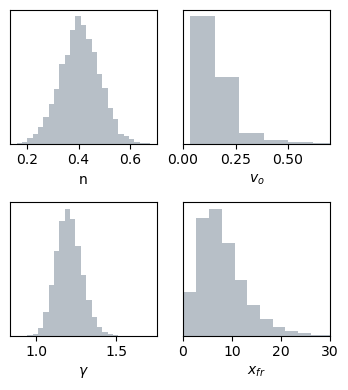

In [77]:
# Estimating model uncertainties

# load Markov chain outputs from MCMC fit to density decay to fracture population 
# (each set of three columns represents the values of vo, d, and gamma for one 
# walker in the ensemble, for a total of 200 walkers)

Markov_chain_density = pd.read_csv('MCMC_outputs/general_density_parameters.txt',sep=' ',header=None).values

# sigma_a = 0.2557 # from regression to FDHI data
# sigma_b = 0.1288
a = 6.8701
b = 0.9629

n_draws = 5000

vo_ensemble, xfr_ensemble, gamma_ensemble, n_distribution = model_uncertainties(Markov_chain_density,mean_n,std_n,n_draws)


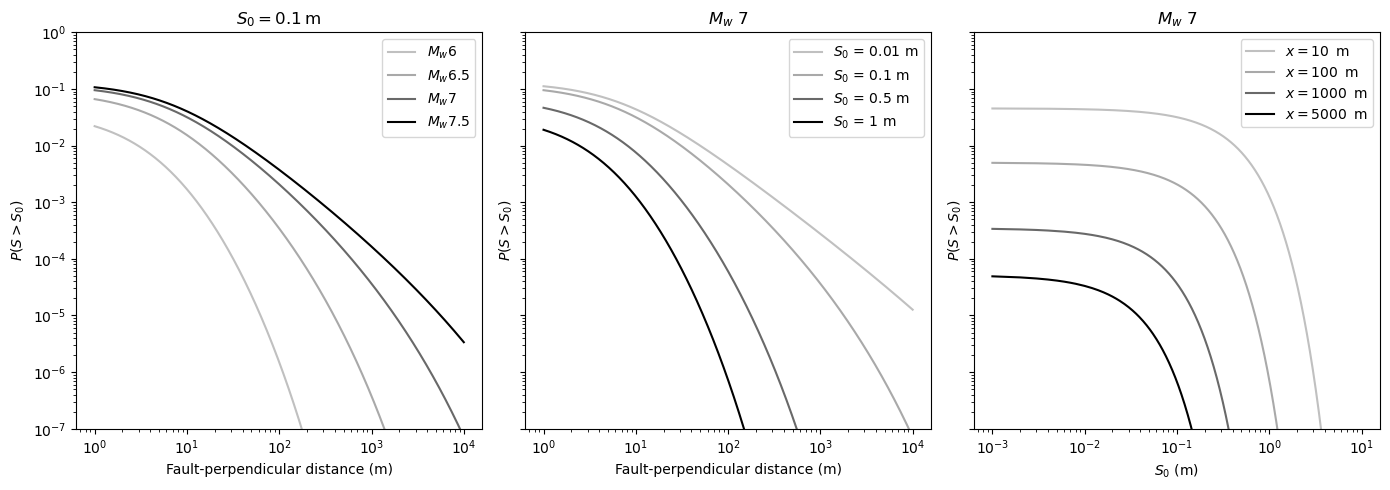

In [78]:
So = 0.1
Mw = [6,6.5,7,7.5]

fig, AX = plt.subplots(1,3,dpi=100,figsize=(14,5),sharey=True)

labels = ['$M_{w} 6$','$M_{w} 6.5$','$M_{w} 7$','$M_{w} 7.5$']
color = ['silver','darkgrey','dimgray','black']
x = np.logspace(np.log10(1),np.log10(10000),1000)

for i in range(len(Mw)):
    P_S_So_bestfit = PFDHAmodel(So,Mw[i],x,mean_n,general_vo,general_xfr,general_g,color[i],1,labels[i],a,b,0,'x')
    
    AX[0].set_xscale('log')
    AX[0].set_yscale('log')
    AX[0].set_ylabel('$P(S>S_{0}$)')
    AX[0].set_title('$S_0 = %s \N{thin space}$m' %So)
    AX[0].set_xlabel('Fault-perpendicular distance (m)')
    AX[0].set_ylim(10**-7,1.001)

# Put a legend to the right of the current axis
AX[0].legend()

So = [0.01, 0.1, 0.5, 1]
Mw = 7

labels = ['$S_{0}$ = 0.01 m','$S_{0}$ = 0.1 m','$S_{0}$ = 0.5 m','$S_{0}$ = 1 m']
color = ['silver','darkgrey','dimgray','black']

for i in range(len(So)):
    P_S_So_bestfit = PFDHAmodel(So[i],Mw,x,mean_n,general_vo,general_xfr,general_g,color[i],1,labels[i],a,b,1,'x')
    
    AX[1].set_xscale('log')
    AX[1].set_yscale('log')
    AX[1].set_ylabel('$P(S>S_{0}$)')
    AX[1].set_title('$M_w$ 7')
    AX[1].set_xlabel('Fault-perpendicular distance (m)')
    AX[1].set_ylim(10**-7,1.001)

xrange = [10,100,1000,5000]
So_range = np.linspace(10**-3,10,10000)

for i in range(len(xrange)):
    P_S_So_bestfit = []
    for j in range(len(So_range)):
        P_S_So_bestfit.append(PFDHAmodel(So_range[j],Mw,xrange[i],mean_n,general_vo,general_xfr,general_g,color[i],1,labels[i],a,b,1,'disp'))
    AX[2].plot(So_range,P_S_So_bestfit,color[i],label='$x = %s \N{thin space}$ m' %xrange[i])
    
    
    AX[2].set_xscale('log')
    AX[2].set_yscale('log')
    AX[2].set_ylabel('$P(S>S_{0}$)')
    AX[2].set_title('$M_w$ 7')
    AX[2].set_xlabel(r'$S_{0}$ (m)')
    AX[2].set_ylim(10**-7,1.001)
AX[2].legend()

# Put a legend to the right of the current axis
AX[1].legend()

plt.tight_layout()
plt.savefig('Model_outputs/PFDHAmodel_general_3S0_Mw7.pdf')
plt.show()


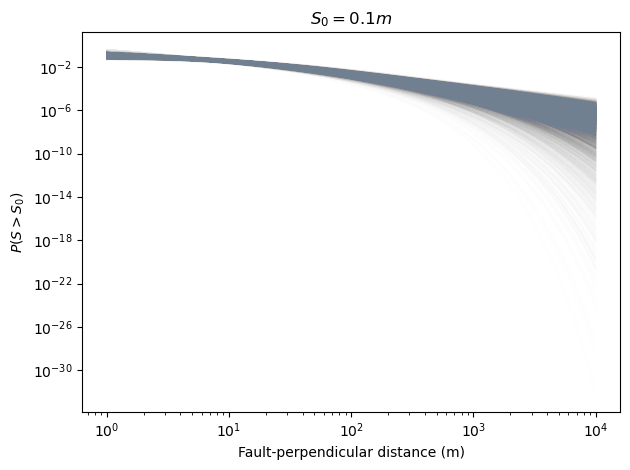

In [79]:
# for an individual model of a single magnitude

So = 0.1
Mw = 7
P_S_So_bestfit = PFDHAmodel(So,Mw,x,mean_n,general_vo,general_xfr,general_g,'slategrey',1,'$M_w$ 7',a,b,1,'x')
# arrays for calculating confidence intervals 
PS_So = []
residuals = []

plt.figure()

# from regression (see Matlab secript)
N = 31
mean_mag = 6.7261
sum_diff_sqrs = 12.8223
rmse = 0.4611

for i in range(5000):
    # standard error for mean displacement given magnitude
    other_mw = np.sqrt((1/N)+((Mw-mean_mag)**2)/sum_diff_sqrs**2)
    se_mw = rmse*other_mw
    # assuming standard error is standard deviation, draw from normal distribution where preferred beta is the mean and se is the standard deviation, done in function
    i_PS_So = PFDHAmodel(So,Mw,x,n_distribution[i],vo_ensemble[i],xfr_ensemble[i],gamma_ensemble[i],'slategrey',0.002,'',a,b,999,'x',se_mw)
    PS_So.append(i_PS_So)
    residuals.append(np.log(i_PS_So) - np.log(P_S_So_bestfit))
    #PFDHAmodel(So,Mw,x,mean_n,general_vo,general_xfr,general_g,'firebrick',1,'',a,b,999,'x')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P(S>S_{0}$)')

plt.title('$S_0 = %s m$' %So)
plt.xlabel('Fault-perpendicular distance (m)')
#plt.ylim(10**-7,1)

PS_So = np.array(PS_So)
residuals = np.array(residuals)
assert PS_So.shape == residuals.shape

sigma_16_PS_So = np.percentile(PS_So,16,axis=0) # 16
sigma_84_PS_So = np.percentile(PS_So,84,axis=0) # 84
sigma_16_res = np.percentile(residuals,16,axis=0)
sigma_84_res = np.percentile(residuals,84,axis=0)

# Put a legend to the right of the current axis
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
# plt.savefig('ModeoPFDHAmodel_general.pdf')
plt.show()

In [80]:
def expc(x, a):
    return a*np.exp(x**0.15)


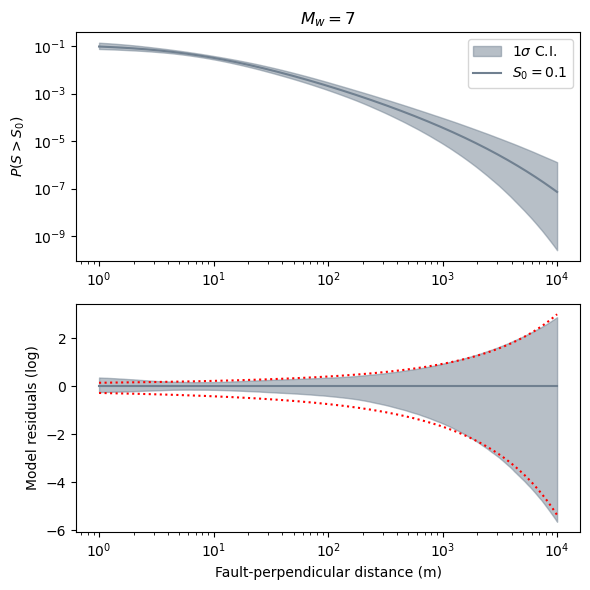

In [81]:

fig, AX = plt.subplots(2,1,dpi=100,figsize=(6,6)) # ,sharex=True

line_spec = {
    "alpha":0.5,
    "color":"slategrey",
    "label":"1$\sigma$ C.I."
}

x = np.logspace(np.log10(1),np.log10(10000),1000)

AX[0].fill_between(x,sigma_16_PS_So,sigma_84_PS_So, **line_spec)
AX[1].fill_between(x,sigma_16_res, sigma_84_res, **line_spec)

popt84, pcov84 = curve_fit(expc, x, sigma_84_res)
popt16, pcov16 = curve_fit(expc, x, sigma_16_res)
AX[1].plot(x, expc(x, *popt84), c='r',linestyle=':')
AX[1].plot(x, expc(x, *popt16), c='r',linestyle=':')

AX[0].set_yscale('log')
AX[0].set_xscale('log')
AX[0].set_ylabel('$P(S>S_{0})$')
AX[0].plot(x,P_S_So_bestfit,c='slategrey',label='$S_{0} = %.1f$' %(So))
AX[0].legend()
AX[0].set_title('$M_w = %s$' %Mw)
AX[1].plot(x,np.log(P_S_So_bestfit)-np.log(P_S_So_bestfit), color='slategrey')
AX[1].set_xscale('log')
AX[1].set_xlabel('Fault-perpendicular distance (m)')
AX[1].set_ylabel('Model residuals (log)')

plt.tight_layout()

plt.savefig('Model_outputs/General_model_uncert.pdf')
plt.show()

In [82]:
popt16

array([-0.10016689])

In [83]:
popt84

array([0.05619148])

In [84]:
import random

# quick test 
Mw = 5
b = 0.8
a = -6

y2 = 10**(Mw*b+a)
y1 = 10**((Mw*b)/a)

# Parameters for the random noise
mean = 0.0      # Mean of the noise (for normal distribution)
std_dev = 0.2   # Standard deviation of the noise (for normal distribution)


# Adding random noise (choose one of the following methods)

# Method 1: Using normal distribution
noisy_value_y2 = y2 + random.normalvariate(mean, std_dev)
noisy_value_y1 = y1 + random.normalvariate(mean, std_dev)

